# 3.3 Model Building - LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

## Installing Dependecies for LGBM with GPU [[1]](https://www.kaggle.com/code/abhishek/running-lightgbm-on-gpu/notebook)

In [ ]:
# !pip uninstall -y lightgbm
# !apt-get install -y libboost-all-dev
# !git clone --recursive https://github.com/Microsoft/LightGBM

In [ ]:
# %%bash
# cd LightGBM
# rm -r build
# mkdir build
# cd build
# cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
# make -j$(nproc)

In [ ]:
# !cd LightGBM/python-package/;python setup.py install --precompile

In [ ]:
# !mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# !rm -r LightGBM

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import gc
import psutil
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

import lightgbm as lgb
from bayes_opt import BayesianOptimization

## Importing aggregated training dataset

[Aggregated Dataset](https://www.kaggle.com/datasets/manishcjain/msba-6420-predictive-analytics-project)

In [2]:
train = pd.read_csv("../input/msba-6420-predictive-analytics-project/Alldata_v3/train.csv",low_memory=False)
train = train.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_DAYS_ENTRY_PAYMENT_MIN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_SUM
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-587.0,-49.0,-315.421053,-5993.0
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-2324.0,-544.0,-1385.320000,-34633.0
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-795.0,-727.0,-761.666667,-2285.0
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-575.0,-12.0,-271.625000,-4346.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-2318.0,-14.0,-1032.242424,-68128.0


## Using Bayesian Optimization for Hyperparameter tuning LGBM Classifier
**Bayesian Optimization**[[2]](https://github.com/fmfn/BayesianOptimization)
> Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not.

**HyperParameters for LightGBM**[[3]](https://www.kaggle.com/code/sz8416/simple-bayesian-optimization-for-lightgbm) [[4]](https://www.kaggle.com/code/hikmetsezen/base-model-with-0-804-auc-on-home-credit) [[5]](https://lightgbm.readthedocs.io/en/latest/Parameters.html)
* **n_estimators** - Number of boosting iterations
* **learning_rate** - Shrinkage rate of the gradient
* **max_depth** - limit the max depth for tree model
* **num_leaves** - max number of leaves in one tree
* **colsample_bytree** - Size of the subset of features on each iteration (tree) as a % of total size 
* **bagging_fraction** - Randomly select part of data without resampling
* **reg_alpha** -L1 regularization
* **lambda_l2** - L2 regularization
* **min_split_gain** - the minimal gain to perform split
* **min_child_weight** - minimal sum hessian in one leaf.
* **min_child_samples** - minimal number of data in one leaf
* **scale_pos_weight** - weight of labels with positive class

In [3]:
def LGB_CV(n_estimators,learning_rate, max_depth, num_leaves, colsample_bytree,bagging_fraction,reg_alpha,lambda_l2,min_split_gain,min_child_weight,min_child_samples):
    params = {'application':'binary',
              'early_stopping_round':40,
              'metric':'auc',
              'device':'gpu',
              'gpu_platform_id':0,
              'gpu_device_id':0,
              'max_bin':150
             }
    params["n_estimators"] = int(n_estimators)
    params["learning_rate"] = learning_rate
    params["num_leaves"] = int(round(num_leaves))
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['reg_alpha'] = max(reg_alpha, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params['min_child_samples'] = int(round(min_child_samples))
    cv_result = lgb.cv(params, lgb.Dataset(data=train.drop(columns=['TARGET','SK_ID_CURR']), label=train['TARGET']), nfold=5, seed=6, stratified=True,metrics=['auc'],verbose_eval=False)
    
    return max(cv_result['auc-mean'])

In [4]:
LightGBM_BO = BayesianOptimization(LGB_CV,{
    'num_leaves': (10, 30),
    'n_estimators':(3000,10000),
    'learning_rate':(0.009,0.2),
    'colsample_bytree': (0.1, 0.9),
    'bagging_fraction': (0.5, 1),
    'max_depth': (5, 13),
    'reg_alpha': (0, 10),
    'lambda_l2': (0, 10),
    'min_split_gain': (0.001, 0.3),
    'min_child_weight': (1, 50),
    'min_child_samples':(50,200)
},random_state=0, verbose=200)

LightGBM_BO.maximize(init_points=1, n_iter=20)

|   iter    |  target   | baggin... | colsam... | lambda_l2 | learni... | max_depth | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19859, number of negative: 226145
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 72698
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 882
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 432 dense feature groups (101.35 MB) transferred to GPU in 0.207553 secs. 1 sparse feature groups
[LightGBM] [Info] Num

## 1. Building a Model with the best parameters - No handling for Imbalanced data

In [8]:
clf1 = lgb.LGBMClassifier(objective='binary',
                         metric='auc',
                         device='gpu',
                         gpu_platform_id=0,
                         gpu_device_id=0,
                         max_bin=150,
                         bagging_fraction= LightGBM_BO.max['params']['bagging_fraction'],
                         colsample_bytree= LightGBM_BO.max['params']['colsample_bytree'],
                         lambda_l2= LightGBM_BO.max['params']['lambda_l2'],
                         learning_rate= LightGBM_BO.max['params']['learning_rate'],
                         max_depth= int(round(LightGBM_BO.max['params']['max_depth'])),
                         min_child_weight= LightGBM_BO.max['params']['min_child_weight'],
                         min_split_gain= LightGBM_BO.max['params']['min_split_gain'],
                         n_estimators= int(round(LightGBM_BO.max['params']['n_estimators'])),
                         num_leaves= int(round(LightGBM_BO.max['params']['num_leaves'])),
                         reg_alpha= LightGBM_BO.max['params']['reg_alpha'],
                         min_child_samples = int(round(LightGBM_BO.max['params']['min_child_samples'])))
clf1

LGBMClassifier(bagging_fraction=0.5912384186379205,
               colsample_bytree=0.22489950447691787, device='gpu',
               gpu_device_id=0, gpu_platform_id=0, lambda_l2=7.2476570775749085,
               learning_rate=0.010091730086664408, max_bin=150, max_depth=12,
               metric='auc', min_child_samples=148,
               min_child_weight=18.396999797852718,
               min_split_gain=0.15249740640007858, n_estimators=9751,
               num_leaves=21, objective='binary', reg_alpha=1.6477598520053405)

In [9]:
clf1.fit(train.drop(columns=['TARGET','SK_ID_CURR']),train['TARGET'], eval_metric= 'roc_auc',verbose=200)

[LightGBM] [Warning] bagging_fraction is set=0.5912384186379205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5912384186379205
[LightGBM] [Warning] lambda_l2 is set=7.2476570775749085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2476570775749085


LGBMClassifier(bagging_fraction=0.5912384186379205,
               colsample_bytree=0.22489950447691787, device='gpu',
               gpu_device_id=0, gpu_platform_id=0, lambda_l2=7.2476570775749085,
               learning_rate=0.010091730086664408, max_bin=150, max_depth=12,
               metric='auc', min_child_samples=148,
               min_child_weight=18.396999797852718,
               min_split_gain=0.15249740640007858, n_estimators=9751,
               num_leaves=21, objective='binary', reg_alpha=1.6477598520053405)

## Tree-based Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

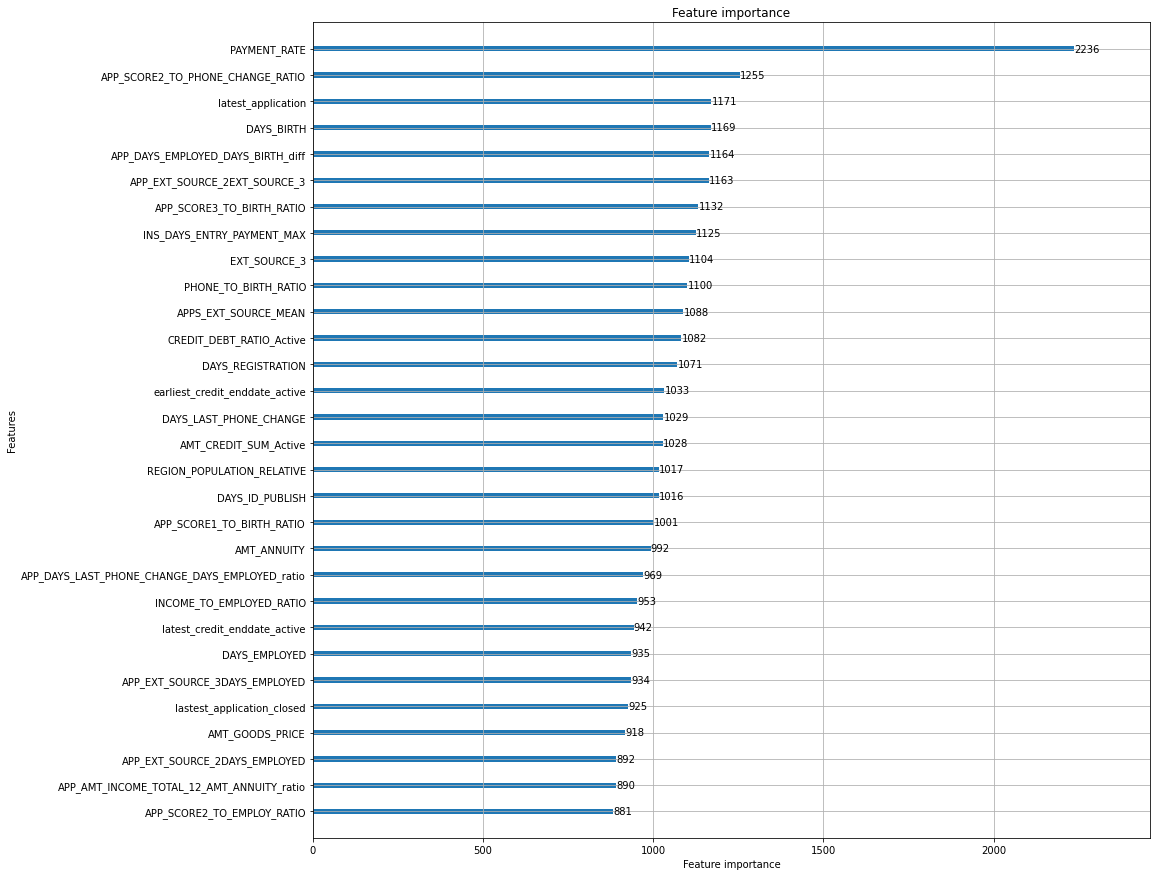

In [10]:
lgb.plot_importance(booster=clf1,max_num_features = 30,figsize=(15,15))

In [11]:
test = pd.read_csv("../input/msba-6420-predictive-analytics-project/Alldata_v3/test.csv",low_memory=False)
test = test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

## Result for the model with all features (no scale_pos_weight)

In [12]:
prediction1 = clf1.predict_proba(test.drop(columns=['SK_ID_CURR']))
result1 = pd.DataFrame({'SK_ID_CURR':test['SK_ID_CURR'],
              'TARGET':pd.DataFrame(prediction1)[1]})

result1.to_csv("Result_LGBM1.csv",index=False)

## Tuning the scale_pos_weight parameter to handle imbalanced data

In [5]:
def LGB_CV(scale_pos_weight):
    params = clf1.get_params()
    params['scale_pos_weight'] = int(round(scale_pos_weight))
    params['early_stopping_round'] = 30
    cv_result = lgb.cv(params, lgb.Dataset(data=train.drop(columns=['TARGET','SK_ID_CURR']), label=train['TARGET']), nfold=5, seed=6, stratified=True,metrics=['auc'],verbose_eval=False)
    return max(cv_result['auc-mean'])

In [9]:
LightGBM_BO1 = BayesianOptimization(LGB_CV,{'scale_pos_weight': (2,10)},random_state=0, verbose=-1)

LightGBM_BO1.maximize(init_points=1, n_iter=3)

|   iter    |  target   | scale_... |
-------------------------------------
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] bagging_fraction is set=0.8497981211186849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497981211186849
[LightGBM] [Warning] lambda_l2 is set=8.18198695183353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.18198695183353
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] bagging_fraction is set=0.8497981211186849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497981211186849
[LightGBM] [Warning] lambda_l2 is set=8.18198695183353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.18198695183353
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] bagging_fraction is set=0.84979812111868

## 2. Building a Model with the best parameters - handling for Imbalanced data with scale_pos_weight

In [17]:
clf2 = lgb.LGBMClassifier(objective='binary',
                         metric='auc',
                         device='gpu',
                         gpu_platform_id=0,
                         gpu_device_id=0,
                         max_bin=150,
                         bagging_fraction= LightGBM_BO.max['params']['bagging_fraction'],
                         colsample_bytree= LightGBM_BO.max['params']['colsample_bytree'],
                         lambda_l2= LightGBM_BO.max['params']['lambda_l2'],
                         learning_rate= LightGBM_BO.max['params']['learning_rate'],
                         max_depth= int(round(LightGBM_BO.max['params']['max_depth'])),
                         min_child_weight= LightGBM_BO.max['params']['min_child_weight'],
                         min_split_gain= LightGBM_BO.max['params']['min_split_gain'],
                         n_estimators= int(round(LightGBM_BO.max['params']['n_estimators'])),
                         num_leaves= int(round(LightGBM_BO.max['params']['num_leaves'])),
                         reg_alpha= LightGBM_BO.max['params']['reg_alpha'],
                         min_child_samples = int(round(LightGBM_BO.max['params']['min_child_samples'])),
                         scale_pos_weight = int(round(LightGBM_BO1.max['params']['scale_pos_weight'])))
clf2

LGBMClassifier(bagging_fraction=0.5912384186379205,
               colsample_bytree=0.22489950447691787, device='gpu',
               gpu_device_id=0, gpu_platform_id=0, lambda_l2=7.2476570775749085,
               learning_rate=0.010091730086664408, max_bin=150, max_depth=12,
               metric='auc', min_child_samples=148,
               min_child_weight=18.396999797852718,
               min_split_gain=0.15249740640007858, n_estimators=9751,
               num_leaves=21, objective='binary', reg_alpha=1.6477598520053405,
               scale_pos_weight=2)

In [18]:
clf2.fit(train.drop(columns=['TARGET','SK_ID_CURR']),train['TARGET'], eval_metric= 'roc_auc',verbose=200)

[LightGBM] [Warning] bagging_fraction is set=0.5912384186379205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5912384186379205
[LightGBM] [Warning] lambda_l2 is set=7.2476570775749085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2476570775749085


LGBMClassifier(bagging_fraction=0.5912384186379205,
               colsample_bytree=0.22489950447691787, device='gpu',
               gpu_device_id=0, gpu_platform_id=0, lambda_l2=7.2476570775749085,
               learning_rate=0.010091730086664408, max_bin=150, max_depth=12,
               metric='auc', min_child_samples=148,
               min_child_weight=18.396999797852718,
               min_split_gain=0.15249740640007858, n_estimators=9751,
               num_leaves=21, objective='binary', reg_alpha=1.6477598520053405,
               scale_pos_weight=2)

## Result for the model with all features

In [19]:
prediction2 = clf2.predict_proba(test.drop(columns=['SK_ID_CURR']))
result2 = pd.DataFrame({'SK_ID_CURR':test['SK_ID_CURR'],
              'TARGET':pd.DataFrame(prediction2)[1]})

result2.to_csv("Result_LGBM2.csv",index=False)

## 3. Use the best classifier to build the final model - OOF predicitions

In [3]:
clf3 = clf1

In [10]:
folds = KFold(n_splits = 5, shuffle=True, random_state = 6)
oof_preds = np.zeros(train.shape[0])
prediction3 = np.zeros(test.shape[0])

for fold_idx, (train_idx , valid_idx) in enumerate(folds.split(train.drop(columns=['SK_ID_CURR','TARGET']))):
    print("##### iteration ", fold_idx, 'starts')

    clf3.fit(train.drop(columns=['SK_ID_CURR','TARGET']).iloc[train_idx, :],
                   train['TARGET'].iloc[train_idx],
                   eval_set=[(train.drop(columns=['SK_ID_CURR','TARGET']).iloc[train_idx, :], train['TARGET'].iloc[train_idx]),
                             (train.drop(columns=['SK_ID_CURR','TARGET']).iloc[valid_idx, :], train['TARGET'].iloc[valid_idx])],
                   eval_metric= 'auc', verbose= 200, 
                   early_stopping_rounds= 200)
    gc.collect()
    prediction3 += clf3.predict_proba(test.drop(columns=['SK_ID_CURR'])
                                           ,num_iteration=clf3.best_iteration_)[:, 1] / folds.n_splits
    gc.collect()

##### iteration  0 starts
[LightGBM] [Warning] lambda_l2 is set=8.18198695183353, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.18198695183353
[LightGBM] [Warning] bagging_fraction is set=0.8497981211186849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8497981211186849
[200]	valid_0's auc: 0.776595	valid_1's auc: 0.767259
[400]	valid_0's auc: 0.79312	valid_1's auc: 0.779212
[600]	valid_0's auc: 0.802697	valid_1's auc: 0.785135
[800]	valid_0's auc: 0.809872	valid_1's auc: 0.78839
[1000]	valid_0's auc: 0.815921	valid_1's auc: 0.790386
[1200]	valid_0's auc: 0.821182	valid_1's auc: 0.791464
[1400]	valid_0's auc: 0.825812	valid_1's auc: 0.792346
[1600]	valid_0's auc: 0.83018	valid_1's auc: 0.792862
[1800]	valid_0's auc: 0.834402	valid_1's auc: 0.79331
[2000]	valid_0's auc: 0.838434	valid_1's auc: 0.793664
[2200]	valid_0's auc: 0.842328	valid_1's auc: 0.793958
[2400]	valid_0's auc: 0.846036	valid_1's auc: 0.794145
[2600]	valid_0's auc: 0.849602	valid_1's auc:

## Result for the model with OOF prediction

In [16]:
result3 = pd.DataFrame({'SK_ID_CURR':test['SK_ID_CURR'],
              'TARGET':predicition3})

result3.to_csv("Result_LGBM3.csv",index=False)

## 4. Building a model with top 400 features

In [6]:
clf4 = clf1
clf4

LGBMClassifier(bagging_fraction=0.5912384186379205,
               colsample_bytree=0.22489950447691787, device='gpu',
               gpu_device_id=0, gpu_platform_id=0, lambda_l2=7.2476570775749085,
               learning_rate=0.010091730086664408, max_bin=150, max_depth=12,
               metric='auc', min_child_samples=148,
               min_child_weight=18.396999797852718,
               min_split_gain=0.15249740640007858, n_estimators=9751,
               num_leaves=21, objective='binary', reg_alpha=1.6477598520053405)

In [8]:
clf4.fit(train.drop(columns=['TARGET','SK_ID_CURR']),train['TARGET'], eval_metric= 'roc_auc',verbose=200)

[LightGBM] [Warning] bagging_fraction is set=0.5912384186379205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5912384186379205
[LightGBM] [Warning] lambda_l2 is set=7.2476570775749085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.2476570775749085


LGBMClassifier(bagging_fraction=0.5912384186379205,
               colsample_bytree=0.22489950447691787, device='gpu',
               gpu_device_id=0, gpu_platform_id=0, lambda_l2=7.2476570775749085,
               learning_rate=0.010091730086664408, max_bin=150, max_depth=12,
               metric='auc', min_child_samples=148,
               min_child_weight=18.396999797852718,
               min_split_gain=0.15249740640007858, n_estimators=9751,
               num_leaves=21, objective='binary', reg_alpha=1.6477598520053405)

## Selecting Top 400 features

In [20]:
feature_importance = pd.DataFrame({'feature':clf4.feature_name_,
                                   'importance':clf4.feature_importances_}).sort_values(by='importance',ascending=False).reset_index(drop=True)
top400 = feature_importance.iloc[:400,0].to_list()

In [21]:
clf4.fit(train[top400],train['TARGET'], eval_metric= 'roc_auc',verbose=200)

LGBMClassifier(bagging_fraction=0.5912384186379205,
               colsample_bytree=0.22489950447691787, device='gpu',
               gpu_device_id=0, gpu_platform_id=0, lambda_l2=7.2476570775749085,
               learning_rate=0.010091730086664408, max_bin=150, max_depth=12,
               metric='auc', min_child_samples=148,
               min_child_weight=18.396999797852718,
               min_split_gain=0.15249740640007858, n_estimators=9751,
               num_leaves=21, objective='binary', reg_alpha=1.6477598520053405)

In [23]:
test = pd.read_csv("../input/msba-6420-predictive-analytics-project/Alldata_v3/test.csv",low_memory=False)
test = test.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
prediction4 = clf4.predict_proba(test[top400])
result4 = pd.DataFrame({'SK_ID_CURR':test['SK_ID_CURR'],
              'TARGET':pd.DataFrame(prediction4)[1]})

result4.to_csv("Result_LGBM4.csv",index=False)